# Model-theoretic ontology embedding methods

## EL-Embeddings

Import MOWL library and ELEmbedding model base classes

In [1]:
import mowl
mowl.init_jvm("10g")

from mowl.models.elembeddings.module import ELEmModule
from mowl.base_models.elmodel import EmbeddingELModel


/home/kulmanm/anaconda3/envs/deepgo2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Define the model and training strategy

In [2]:
import torch
from torch import nn
from tqdm import trange
import numpy as np

class ELEmbeddings(EmbeddingELModel):

    def __init__(self,
                 dataset,
                 embed_dim=50,
                 margin=0,
                 reg_norm=1,
                 learning_rate=0.001,
                 epochs=1000,
                 batch_size=4096 * 8,
                 model_filepath=None,
                 device='cpu'
                 ):
        super().__init__(dataset, batch_size, extended=True, model_filepath=model_filepath)

        self.embed_dim = embed_dim
        self.margin = margin
        self.reg_norm = reg_norm
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.device = device
        self._loaded = False
        self._loaded_eval = False
        self.extended = False
        self.init_model()

    def init_model(self):
        self.model = ELEmModule(
            len(self.class_index_dict),  # number of ontology classes
            len(self.object_property_index_dict),  # number of ontology object properties
            embed_dim=self.embed_dim,
            margin=self.margin
        ).to(self.device)

    def train(self, checkpoint=1):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        best_loss = float('inf')

        for epoch in trange(self.epochs):
            self.model.train()

            train_loss = 0
            loss = 0

            # Notice how we use the ``training_datasets`` variable directly
            # and every element of it is a pair (GCI name, GCI tensor data).
            for gci_name, gci_dataset in self.training_datasets.items():
                if len(gci_dataset) == 0:
                    continue
                loss += torch.mean(self.model(gci_dataset[:], gci_name))
                
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.detach().item()
            torch.save(self.model.state_dict(), self.model_filepath)
            if (epoch + 1) % checkpoint == 0:
                print(f'\nEpoch {epoch}: Train loss: {train_loss:4f}')

Create the dataset class

In [3]:
from mowl.datasets import PathDataset

family_dataset = PathDataset('data/family.owl')

Train the model

In [17]:
elembeddings = ELEmbeddings(family_dataset,
                     embed_dim=2,
                     margin=0.1,
                     reg_norm=1,
                     learning_rate=0.01,
                     epochs=1000,
                     batch_size=2,
                     model_filepath=None,
                     device='cpu')

elembeddings.train(checkpoint=100)

 15%|█████████████▏                                                                        | 154/1000 [00:00<00:02, 392.15it/s]


Epoch 99: Train loss: 0.027678


 28%|███████████████████████▉                                                              | 278/1000 [00:00<00:01, 404.85it/s]


Epoch 199: Train loss: 0.007596


 36%|███████████████████████████████                                                       | 361/1000 [00:00<00:01, 406.96it/s]


Epoch 299: Train loss: 0.011696


 44%|██████████████████████████████████████▏                                               | 444/1000 [00:01<00:01, 407.53it/s]


Epoch 399: Train loss: 0.008251


 57%|████████████████████████████████████████████████▊                                     | 568/1000 [00:01<00:01, 406.96it/s]


Epoch 499: Train loss: 0.017045


 65%|███████████████████████████████████████████████████████▉                              | 650/1000 [00:01<00:00, 407.31it/s]


Epoch 599: Train loss: 0.015245


 77%|██████████████████████████████████████████████████████████████████▌                   | 774/1000 [00:01<00:00, 408.97it/s]


Epoch 699: Train loss: 0.010562


 86%|█████████████████████████████████████████████████████████████████████████▌            | 856/1000 [00:02<00:00, 408.32it/s]


Epoch 799: Train loss: 0.011237


 98%|████████████████████████████████████████████████████████████████████████████████████▏ | 979/1000 [00:02<00:00, 406.72it/s]


Epoch 899: Train loss: 0.004691


100%|█████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 402.81it/s]


Epoch 999: Train loss: 0.010743


Extract embeddings

In [18]:
embeds = elembeddings.model.class_embed.weight.cpu().detach().numpy()
rs = np.abs(elembeddings.model.class_rad.weight.cpu().detach().numpy())
classes = list(elembeddings.class_index_dict.keys())
rs, embeds

(array([[0.07460205],
        [0.31565478],
        [0.5132675 ],
        [0.33170095],
        [1.0727464 ],
        [1.5564307 ],
        [1.        ],
        [1.        ]], dtype=float32),
 array([[ 0.547447  ,  0.8335899 ],
        [ 0.93861824,  0.3471531 ],
        [ 0.13891678,  0.9894528 ],
        [ 0.9208374 ,  0.389781  ],
        [ 0.9730775 , -0.22969688],
        [ 0.9494873 ,  0.3084904 ],
        [ 0.9998626 , -0.01657875],
        [-0.6967883 ,  0.71727675]], dtype=float32))

Plot embeddings

<module 'matplotlib.pyplot' from '/home/kulmanm/anaconda3/envs/deepgo2/lib/python3.9/site-packages/matplotlib/pyplot.py'>

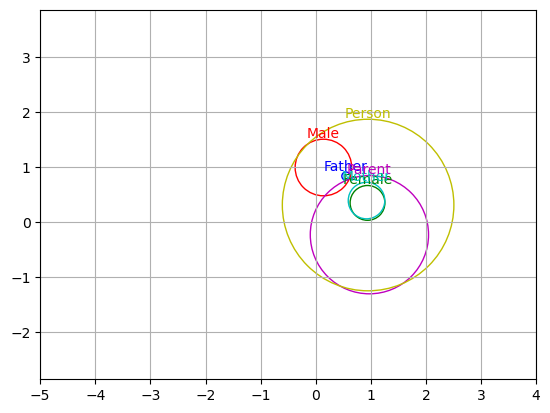

In [19]:
import matplotlib.pyplot as plt

classes = [item.split('/')[-1] for item in classes]
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
fig, ax =  plt.subplots()
plt.axis('equal')
ax.set_xlim(-5, 4)
ax.set_ylim(-3, 4)
for i in range(embeds.shape[0]):
    if classes[i].endswith('hing'):
        continue
    x, y = embeds[i, 0], embeds[i, 1]
    r = rs[i]
    ax.add_artist(plt.Circle(
        (x, y), r, fill=False, edgecolor=colors[i % len(colors)], label=classes[i]))
    ax.annotate(classes[i], xy=(x, y + r + 0.03), fontsize=10, ha="center", color=colors[i % len(colors)])
ax.grid(True)
plt
